In [1]:
import sys
sys.path.append('..')

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from sw_at_datamodule_v3 import SlowWaveATData_v3
from lightning_modules.resnet_sw_activation_time_v3 import ResnetSlowWaveAT_v3

model = ResnetSlowWaveAT_v3()
data_mod = SlowWaveATData_v3('../data/SeqSlowWaveDataset/version_1/images/')

trainer = Trainer(gpus=1, 
                  max_epochs=5, 
                  val_check_interval=0.25, 
                  logger=TensorBoardLogger('logs', name='slow_wave_AT_detection_v3'), 
                  fast_dev_run=False
)
trainer.fit(model, data_mod)

trainer.save_checkpoint('sw_AT_model_v3.ckpt')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 23.5 M
1 | classifier        | Linear     | 4.1 K 
2 | regressor         | Linear     | 2.0 K 
-------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.057    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

# Evaluate the model

In [2]:
import sys
sys.path.append('..')

from pytorch_lightning import Trainer
from sw_at_datamodule_v3 import SlowWaveATData_v3
from lightning_modules.resnet_sw_activation_time_v3 import ResnetSlowWaveAT_v3

model = ResnetSlowWaveAT_v3.load_from_checkpoint('sw_AT_model.ckpt')
data_mod = SlowWaveATData_v3('../data/SeqSlowWaveDataset/version_1/images/', batch_size=32)

trainer = Trainer(gpus=1, max_epochs=5, val_check_interval=0.25)

predictions = trainer.predict(model, data_mod)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [3]:
import numpy as np
import pandas as pd

num_batches = len(predictions)
numpy_data = np.zeros((0, 7), dtype=np.float32)

for batch_indx in range(num_batches):
    batch_size = len(predictions[0][1])
    
    y_class, y_num_sw, y_AT, class_probs, y_hat_AT = predictions[batch_indx]
    class_preds = class_probs.argmax(dim=1)
    
    y_class = y_class.cpu().numpy().reshape(-1, 1)
    y_num_sw = y_num_sw.cpu().numpy().reshape(-1, 1)
    y_AT = y_AT.cpu().numpy().reshape(-1, 1)
    class_probs = class_probs.cpu().numpy()
    class_preds = class_preds.cpu().numpy().reshape(-1, 1)
    y_hat_AT = y_hat_AT.cpu().numpy().reshape(-1, 1)
    
    numpy_data = np.vstack((numpy_data, np.hstack((y_class, y_num_sw, y_AT, class_probs, class_preds, y_hat_AT))))
    
df = pd.DataFrame(data=numpy_data, columns=['Label class', 'Number of slow waves', 'Label AT', 'No slow wave prob', 'Slow wave prob', 'Prediction', 'Predicted AT'])
df.head()

,Label class,Number of slow waves,Label AT,No slow wave prob,Slow wave prob,Prediction,Predicted AT
0,0.0,0.0,-1.00,0.994586,0.005414,0.0,-0.866067
1,0.0,0.0,-1.00,0.999859,0.000141,0.0,-0.986102
2,0.0,0.0,-1.00,0.999997,0.000003,0.0,-1.044115
3,1.0,1.0,2.77,0.000527,0.999473,1.0,3.061904
4,1.0,1.0,2.50,0.001352,0.998648,1.0,2.507484


## Evaluate slow wave classification

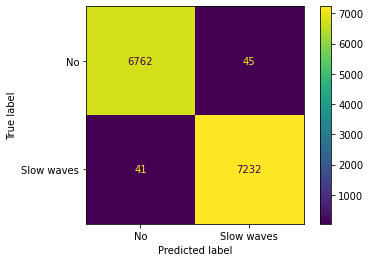

F1 score = 0.994089


In [4]:
import sklearn.metrics as skmetrics
import matplotlib.pyplot as plt

cm = skmetrics.confusion_matrix(df['Label class'], df['Prediction'], labels=[0, 1])
cm_map = skmetrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Slow waves'])
cm_map.plot()
plt.show()

f1 = skmetrics.f1_score(df['Label class'], df['Prediction'])
print('F1 score = {:f}'.format(f1))

## Evaluate slow wave activation time (AT) prediction

In [5]:
r2 = skmetrics.r2_score(df['Label AT'], df['Predicted AT'])
mae = skmetrics.mean_absolute_error(df['Label AT'], df['Predicted AT'])

print('R2 score = {:f}'.format(r2))
print('Mean absolute error = {:f} s'.format(mae))

R2 score = 0.960529
Mean absolute error = 0.133114 s


The r2 score is close to 1. That means, our model can predict the slow wave activation time way better than just giving the mean. There is a 0.13 s error in the predicted activation times.

What is the error distribution like? Do errors come from slow waves being at the edges of the scalogram?

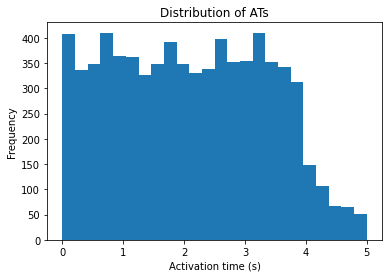

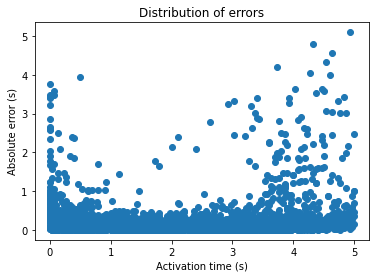

In [6]:
# Find the distribution of activation times in the dataset.

import matplotlib.pyplot as plt

label_AT = df['Label AT']
AT_error =abs(df['Label AT'] - df['Predicted AT'])

AT_error = AT_error[label_AT != -1]
label_AT = label_AT[label_AT != -1]

plt.hist(x=label_AT, bins='auto')
plt.xlabel('Activation time (s)')
plt.ylabel('Frequency')
plt.title('Distribution of ATs')
plt.show()

plt.scatter(x=label_AT, y=AT_error)
plt.xlabel('Activation time (s)')
plt.ylabel('Absolute error (s)')
plt.title('Distribution of errors')
plt.show()

The error in activation times seems to be higher when the slow wave is closer to the edges of the scalogram.

Is the error high because there are multiple slow waves in the scalogram?